In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import os
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_val_predict,cross_val_score, GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import confusion_matrix,classification_report,f1_score,recall_score,precision_score,accuracy_score,precision_recall_curve,roc_curve,roc_auc_score

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

#from imblearn.over_sampling import SMOTE
#from imblearn.combine import SMOTEENN
#from collections import Counter

from scipy.stats import norm, multivariate_normal

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import warnings
warnings.filterwarnings('ignore')


C:\Users\Sinchit Rajput\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
os.chdir('C:/Users/Sinchit Rajput/Projects/Amex Hackathon')

In [3]:
data = pd.read_csv('C:/Users/Sinchit Rajput/Projects/Amex Hackathon/train_amex/train.csv')

In [4]:
data.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,140690,2017-07-02 00:00,858557,C,359520,13787,4,NaN,10.0,Female,4.0,3.0,3.0,0,0
1,333291,2017-07-02 00:00,243253,C,105960,11085,5,NaN,8.0,Female,2.0,2.0,NaN,0,0
2,129781,2017-07-02 00:00,243253,C,359520,13787,4,NaN,8.0,Female,2.0,2.0,NaN,0,0
3,464848,2017-07-02 00:00,1097446,I,359520,13787,3,NaN,3.0,Male,3.0,3.0,2.0,1,0
4,90569,2017-07-02 00:01,663656,C,405490,60305,3,NaN,2.0,Male,2.0,3.0,2.0,1,0


In [5]:
def data_preparation(data):
    features = data.iloc[:,0:-1]
    label = data.iloc[:,-1]
    x_train,x_test,y_train,y_test = train_test_split(features,label,test_size=0.3,random_state=200)

    #Standarad scaler is not applied since all the features are outcomes of PCA and are already normalized.
    sc = StandardScaler()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)
    
    print("Length of training data",len(x_train))
    print("Length of test data",len(x_test))
    return x_train,x_test,y_train,y_test

In [6]:
def build_model_train_test(model,x_train,x_test,y_train,y_test):
    model.fit(x_train,y_train)

    y_pred = model.predict(x_train)
    
    print("\n----------Accuracy Scores on Train data------------------------------------")
    print("Clasification Report")
    print(classification_report(y_train,y_pred))

    print("F1 Score: ", f1_score(y_train,y_pred))
    print("Precision Score: ", precision_score(y_train,y_pred))
    print("Recall Score: ", recall_score(y_train,y_pred))
    print("\n----------Accuracy Scores on Cross validation data------------------------------------")
    y_pred_cv = cross_val_predict(model,x_train,y_train,cv=5)
    print("F1 Score: ", f1_score(y_train,y_pred_cv))
    print("Precision Score: ", precision_score(y_train,y_pred_cv))
    print("Recall Score: ", recall_score(y_train,y_pred_cv))


    print("\n----------Accuracy Scores on Test data------------------------------------")
    y_pred_test = model.predict(x_test)
    
    #print("Clasification Report")
    #print(classification_report(y_test,y_pred_test))

    print("F1 Score: ", f1_score(y_test,y_pred_test))
    print("Precision Score: ", precision_score(y_test,y_pred_test))
    print("Recall Score: ", recall_score(y_test,y_pred_test))

    #Confusion Matrix
    plt.figure(figsize=(18,6))
    gs = gridspec.GridSpec(1,2)

    ax1 = plt.subplot(gs[0])
    cnf_matrix = confusion_matrix(y_train,y_pred)
    row_sum = cnf_matrix.sum(axis=1,keepdims=True)
    cnf_matrix_norm =cnf_matrix / row_sum
    sns.heatmap(cnf_matrix_norm,cmap='YlGnBu',annot=True)
    plt.title("Normalized Confusion Matrix - Train Data")

#     ax2 = plt.subplot(gs[1])
#     cnf_matrix = confusion_matrix(y_train,y_pred_cv)
#     sns.heatmap(cnf_matrix,cmap='YlGnBu',annot=True,fmt='d')
#     plt.title("Confusion Matrix - CV Data")

    ax3 = plt.subplot(gs[1])
    cnf_matrix = confusion_matrix(y_test,y_pred_test)
    row_sum = cnf_matrix.sum(axis=1,keepdims=True)
    cnf_matrix_norm =cnf_matrix / row_sum
    sns.heatmap(cnf_matrix_norm,cmap='YlGnBu',annot=True)
    plt.title("Normalized Confusion Matrix - Test Data")

In [7]:
def Print_Accuracy_Scores(y,y_pred):
    print("F1 Score: ", f1_score(y,y_pred))
    print("Precision Score: ", precision_score(y,y_pred))
    print("Recall Score: ", recall_score(y,y_pred))

In [8]:
def SelectThresholdByCV(probs,y):
    best_threshold = 0
    best_f1 = 0
    f = 0
    precision =0
    recall=0
    best_recall = 0
    best_precision = 0
    precisions=[]
    recalls=[]
    
    thresholds = np.arange(0.0,1.0,0.001)
    for threshold in thresholds:
        predictions = (probs > threshold)
        f = f1_score(y, predictions)
        precision = precision_score(y, predictions)
        recall = recall_score(y, predictions)
        #print("Threshold {0},Precision {1},Recall {2}".format(threshold,precision,recall))
        
        if f > best_f1:
            best_f1 = f
            best_precision = precision
            best_recall = recall
            best_threshold = threshold

        precisions.append(precision)
        recalls.append(recall)

    #Precision-Recall Trade-off
    plt.plot(thresholds,precisions,label='Precision')
    plt.plot(thresholds,recalls,label='Recall')
    plt.xlabel("Threshold")
    plt.title('Precision Recall Trade Off')
    plt.legend()
    plt.show()

    print ('Best F1 Score %f' %best_f1)
    print ('Best Precision Score %f' %best_precision)
    print ('Best Recall Score %f' %best_recall)
    print ('Best Epsilon Score', best_threshold)

In [9]:
data.isna().sum()

session_id                     0
DateTime                       0
user_id                        0
product                        0
campaign_id                    0
webpage_id                     0
product_category_1             0
product_category_2        365854
user_group_id              18243
gender                     18243
age_level                  18243
user_depth                 18243
city_development_index    125129
var_1                          0
is_click                       0
dtype: int64

In [10]:
data1=data

In [11]:
data1=data1.dropna(axis=0,subset=['gender'])

In [12]:
data1.isna().sum()

session_id                     0
DateTime                       0
user_id                        0
product                        0
campaign_id                    0
webpage_id                     0
product_category_1             0
product_category_2        351379
user_group_id                  0
gender                         0
age_level                      0
user_depth                     0
city_development_index    106886
var_1                          0
is_click                       0
dtype: int64

In [13]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 445048 entries, 0 to 463290
Data columns (total 15 columns):
session_id                445048 non-null int64
DateTime                  445048 non-null object
user_id                   445048 non-null int64
product                   445048 non-null object
campaign_id               445048 non-null int64
webpage_id                445048 non-null int64
product_category_1        445048 non-null int64
product_category_2        93669 non-null float64
user_group_id             445048 non-null float64
gender                    445048 non-null object
age_level                 445048 non-null float64
user_depth                445048 non-null float64
city_development_index    338162 non-null float64
var_1                     445048 non-null int64
is_click                  445048 non-null int64
dtypes: float64(5), int64(7), object(3)
memory usage: 54.3+ MB


In [14]:
data1=data1.drop(['city_development_index','product_category_2','session_id','user_id','DateTime'],1)

In [15]:
data1.isna().sum()

product               0
campaign_id           0
webpage_id            0
product_category_1    0
user_group_id         0
gender                0
age_level             0
user_depth            0
var_1                 0
is_click              0
dtype: int64

In [16]:
data1.head()

,product,campaign_id,webpage_id,product_category_1,user_group_id,gender,age_level,user_depth,var_1,is_click
0,C,359520,13787,4,10.0,Female,4.0,3.0,0,0
1,C,105960,11085,5,8.0,Female,2.0,2.0,0,0
2,C,359520,13787,4,8.0,Female,2.0,2.0,0,0
3,I,359520,13787,3,3.0,Male,3.0,3.0,1,0
4,C,405490,60305,3,2.0,Male,2.0,3.0,1,0


In [17]:
#Counts for is_click in the dataset. As you can see, we have only ratio of 1:13, data is imbalanced.
data1['is_click'].value_counts()

0    414991
1     30057
Name: is_click, dtype: int64

In [44]:
data2=pd.get_dummies(data=data1)

In [46]:
data2.describe()

,campaign_id,webpage_id,product_category_1,user_group_id,age_level,user_depth,var_1,is_click,product_A,product_B,product_C,product_D,product_E,product_F,product_G,product_H,product_I,product_J,gender_Female,gender_Male
count,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000
mean,308266.086063,29628.563697,3.084616,3.477396,2.782266,2.878415,0.427817,0.067537,0.032994,0.047775,0.354618,0.088808,0.046375,0.014944,0.020546,0.235876,0.137232,0.020831,0.115929,0.884071
std,126462.435825,21502.411747,1.300054,2.412889,1.069701,0.400130,0.494763,0.250949,0.178622,0.213289,0.478398,0.284467,0.210296,0.121331,0.141859,0.424545,0.344093,0.142820,0.320140,0.320140
min,82320.000000,1734.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,118601.000000,13787.000000,2.000000,2.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,359520.000000,13787.000000,3.000000,3.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,405490.000000,53587.000000,4.000000,4.000000,3.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,414149.000000,60305.000000,5.000000,12.000000,6.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [140]:
testdata = pd.read_csv('C:/Users/Sinchit Rajput/Projects/Amex Hackathon/test_LNMuIYp/test.csv')

In [141]:
testdata1=testdata.drop(['city_development_index','product_category_2','session_id','user_id','DateTime'],1)

In [142]:
testdata1=pd.get_dummies(data=testdata1)

In [143]:
testdata1.head()

,campaign_id,webpage_id,product_category_1,user_group_id,age_level,user_depth,var_1,product_A,product_B,product_C,product_D,product_E,product_F,product_G,product_H,product_I,product_J,gender_Female,gender_Male
0,404347,53587,1,5.0,5.0,3.0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,118601,28529,3,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,1,0,0,0
2,118601,28529,4,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,1,0,0,0
3,118601,28529,5,1.0,1.0,3.0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,118601,28529,5,9.0,3.0,1.0,1,0,0,0,0,0,0,0,1,0,0,1,0


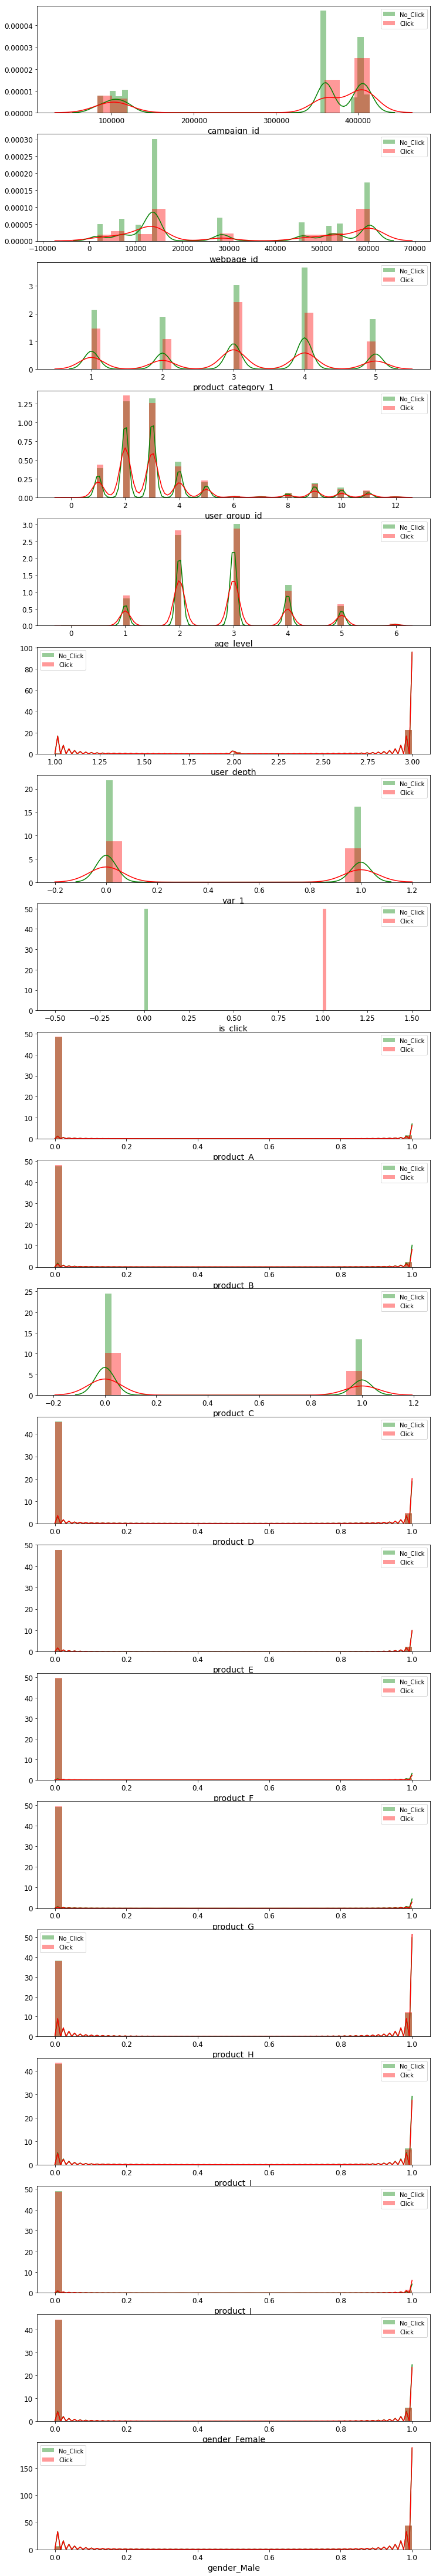

In [53]:
#Data Visualization for checking the distribution for click & no_click cases for each feature
vfeatures = data2.columns
plt.figure(figsize=(12,31*4))
gs = gridspec.GridSpec(31,1)

for i, col in enumerate(vfeatures):
    ax = plt.subplot(gs[i])
    sns.distplot(data2[col][data2['is_click']==0],color='g',label='No_Click')
    sns.distplot(data2[col][data2['is_click']==1],color='r',label='Click')
    ax.legend()
plt.show()

#first five variables are more significant than other

In [58]:
#Splitting the input features and target label into different arrays
x = data2.drop(['is_click'],axis=1)
y = data2.filter(['is_click'],axis=1)
x.columns

Index(['campaign_id', 'webpage_id', 'product_category_1', 'user_group_id',
       'age_level', 'user_depth', 'var_1', 'product_A', 'product_B',
       'product_C', 'product_D', 'product_E', 'product_F', 'product_G',
       'product_H', 'product_I', 'product_J', 'gender_Female', 'gender_Male'],
      dtype='object')

In [59]:
y.columns

Index(['is_click'], dtype='object')

In [60]:
#Train Test split - By default train_test_split does STRATIFIED split based on label (y-value).
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=200)

In [61]:
#Feature Scaling - Standardizing the scales for all x variables
#PN: We should apply fit_transform() method on train set & only transform() method on test set
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [ ]:
#Approach 1 - Adhoc Approach
#In this approach, we applied mutiple models on the data, did error analysis & tried to improve model performance.
#Step1 - SGDClassifier model
#Step2 - Ensemble Models

In [62]:
#Build a basic SGDClassifier model
#sgd_cls = SGDClassifier(class_weight='balanced', random_state=0)
#sgd_cls.fit(x_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [63]:
#Predict target variable (Y-label)
#y_pred = sgd_cls.predict(x_train)

In [64]:
#Classification_report provides main classification metrics(precision, recall & f1-score) for each class
#print(classification_report(y_train,y_pred))

             precision    recall  f1-score   support

          0       0.94      0.56      0.70    290498
          1       0.07      0.49      0.13     21035

avg / total       0.88      0.55      0.66    311533



In [65]:
#Print_Accuracy_Scores(y_train,y_pred)

F1 Score:  0.12974171961351932
Precision Score:  0.07471907274157578
Recall Score:  0.49217970049916804



----------Accuracy Scores on Train data------------------------------------
Clasification Report
             precision    recall  f1-score   support

          0       0.95      0.01      0.03    290498
          1       0.07      0.99      0.13     21035

avg / total       0.89      0.08      0.03    311533

F1 Score:  0.1267779180674506
Precision Score:  0.06772306192101414
Recall Score:  0.9904920370810554

----------Accuracy Scores on Cross validation data------------------------------------
F1 Score:  0.1155396266315132
Precision Score:  0.06752158700606684
Recall Score:  0.4

----------Accuracy Scores on Test data------------------------------------
F1 Score:  0.12655980341327955
Precision Score:  0.0676121747444624
Recall Score:  0.9875859011305698


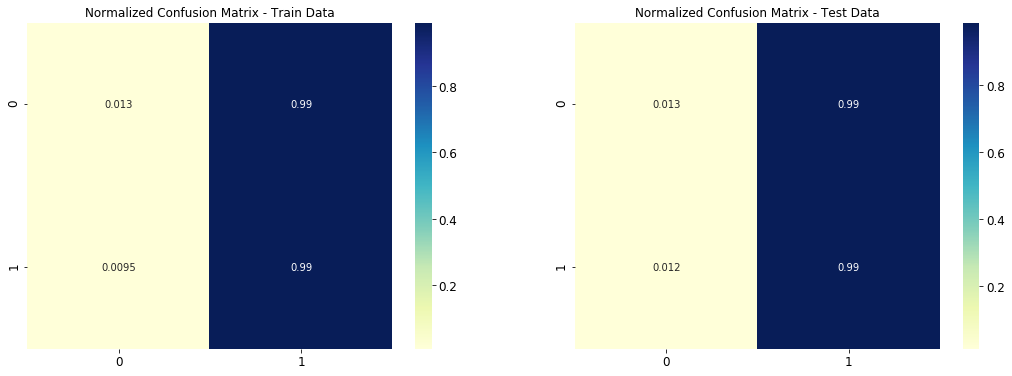

In [70]:
#Build the best model out of GridSearchCV
#best_sgd_clf = SGDClassifier(alpha=5, class_weight='balanced',random_state=0)
#build_model_train_test(best_sgd_clf,x_train,x_test,y_train,y_test)

In [71]:
#featimp = pd.Series(best_sgd_clf.coef_.ravel(),index=x.columns).sort_values(ascending=False)
#print(featimp)

webpage_id            0.016258
product_J             0.005778
var_1                 0.004770
campaign_id           0.004209
gender_Male           0.002644
product_D             0.002393
product_H             0.001833
product_C             0.001382
product_E             0.000333
user_depth           -0.000013
product_A            -0.001631
product_I            -0.002107
gender_Female        -0.002644
product_F            -0.003761
user_group_id        -0.003847
product_B            -0.003885
age_level            -0.003952
product_G            -0.005061
product_category_1   -0.006713
dtype: float64


In [72]:
#Decision scores or Confidence scores - Is a measure of distance of that sample to decision boundary hyperplane
#y_pred_decision = best_sgd_clf.decision_function(x_train)

In [73]:
#Precision recall curve - Computes precision-recall pairs for different probability thresholds
#precisions, recalls, thresholds = precision_recall_curve(y_train,y_pred_decision)

Text(0.5,1,'Precision Recall Curve')

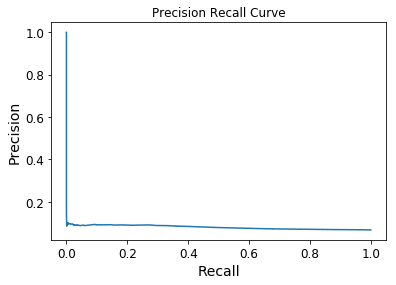

In [74]:
#plt.plot(recalls,precisions)
#plt.xlabel('Recall')
#plt.ylabel('Precision')
#plt.title('Precision Recall Curve')

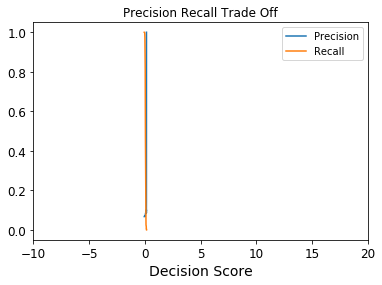

In [75]:
#Precision-Recall Trade-off
#plt.plot(thresholds,precisions[:-1],label='Precision')
#plt.plot(thresholds,recalls[:-1],label='Recall')

#plt.xlabel("Decision Score")
#plt.title('Precision Recall Trade Off')
#plt.legend()
#plt.xlim([-10,20])
#plt.show()

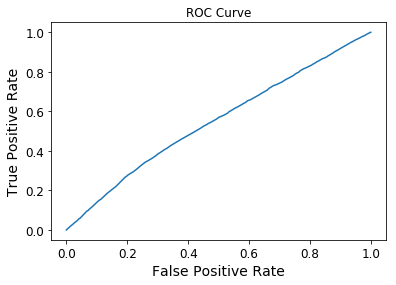

In [76]:
#fpr, tpr, thesholds = roc_curve(y_train,y_pred_decision)

#plt.plot(fpr,tpr)
#plt.xlabel("False Positive Rate")
#plt.ylabel("True Positive Rate")
#plt.title("ROC Curve")
#plt.show()

In [77]:
#roc_auc_score(y_train,y_pred_decision)

0.5490833308203609

In [ ]:
#while submitting the solution score came 0.5 so this model is rejected

In [ ]:
#Step2 - Ensemble Models-Ensemble models may handle imbalanced datasets better due to their nature of building multiple models randomly and aggregate their prediction

In [78]:
# #Use GridSearchCV to find the best parameters for RandomForest algorithm
# param_grid = {
#     'n_estimators':[50,100,200],
#     'max_depth':[4,6,8,10],
#     'min_samples_split':[5,10,20,50]
# }

# rnd_clf = RandomForestClassifier(criterion='gini',class_weight='balanced', n_jobs=-1, random_state=0)
# grid_search = GridSearchCV(rnd_clf,param_grid,cv=5,scoring='f1_weighted')
# grid_search.fit(x_train,y_train)

In [79]:
# grid_search.best_estimator_


----------Accuracy Scores on Train data------------------------------------
Clasification Report
             precision    recall  f1-score   support

          0       0.95      0.62      0.75    290498
          1       0.09      0.53      0.16     21035

avg / total       0.89      0.62      0.71    311533

F1 Score:  0.15795584882683622
Precision Score:  0.09279825634114486
Recall Score:  0.530306631804136

----------Accuracy Scores on Cross validation data------------------------------------
F1 Score:  0.1482241720753408
Precision Score:  0.08739974259096682
Recall Score:  0.4874732588542905

----------Accuracy Scores on Test data------------------------------------
F1 Score:  0.15111421771764275
Precision Score:  0.08890629589738569
Recall Score:  0.5032143648858346


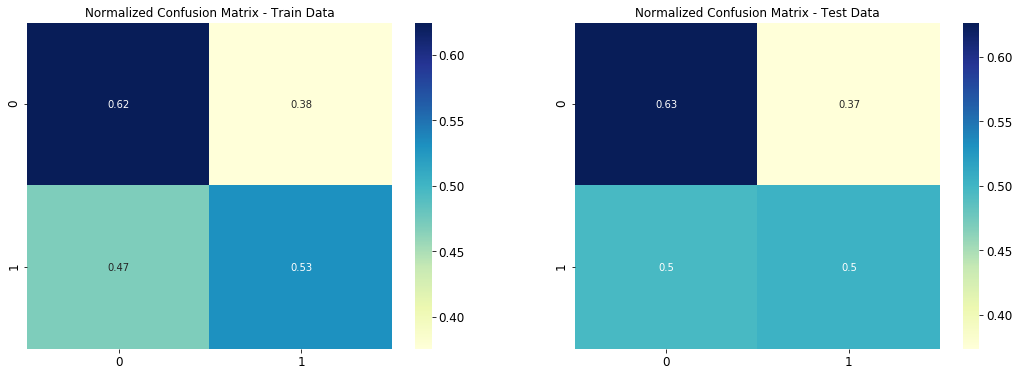

In [80]:
#Best estimator of random forest-grid search was taking lot of time so i did not run it
rnd_clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
build_model_train_test(rnd_clf,x_train,x_test,y_train,y_test)

In [82]:
#Check the Feature importance scores from Random Forest model
featimp = pd.Series(rnd_clf.feature_importances_,index=x.columns).sort_values(ascending=False)
print(featimp)

webpage_id            0.214079
campaign_id           0.165568
product_category_1    0.118982
user_group_id         0.095571
age_level             0.083772
user_depth            0.072033
var_1                 0.056469
product_C             0.031942
product_H             0.029311
product_D             0.024075
product_F             0.019600
product_A             0.013346
product_G             0.013121
product_B             0.012558
product_I             0.011832
gender_Male           0.011788
gender_Female         0.011764
product_J             0.008765
product_E             0.005423
dtype: float64


In [83]:
data2.drop(labels = ['product_E','product_J'], axis = 1, inplace=True)
data2.columns

Index(['campaign_id', 'webpage_id', 'product_category_1', 'user_group_id',
       'age_level', 'user_depth', 'var_1', 'is_click', 'product_A',
       'product_B', 'product_C', 'product_D', 'product_F', 'product_G',
       'product_H', 'product_I', 'gender_Female', 'gender_Male'],
      dtype='object')

In [84]:
data2.describe()

,campaign_id,webpage_id,product_category_1,user_group_id,age_level,user_depth,var_1,is_click,product_A,product_B,product_C,product_D,product_F,product_G,product_H,product_I,gender_Female,gender_Male
count,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000
mean,308266.086063,29628.563697,3.084616,3.477396,2.782266,2.878415,0.427817,0.067537,0.032994,0.047775,0.354618,0.088808,0.014944,0.020546,0.235876,0.137232,0.115929,0.884071
std,126462.435825,21502.411747,1.300054,2.412889,1.069701,0.400130,0.494763,0.250949,0.178622,0.213289,0.478398,0.284467,0.121331,0.141859,0.424545,0.344093,0.320140,0.320140
min,82320.000000,1734.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,118601.000000,13787.000000,2.000000,2.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,359520.000000,13787.000000,3.000000,3.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,405490.000000,53587.000000,4.000000,4.000000,3.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,414149.000000,60305.000000,5.000000,12.000000,6.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [90]:
data2['campaign_id'] = StandardScaler().fit_transform(data2['campaign_id'].values.reshape(-1, 1))

In [92]:
data2['webpage_id'] = StandardScaler().fit_transform(data2['webpage_id'].values.reshape(-1, 1))
data2.describe()                                                   

,campaign_id,webpage_id,product_category_1,user_group_id,age_level,user_depth,var_1,is_click,product_A,product_B,product_C,product_D,product_F,product_G,product_H,product_I,gender_Female,gender_Male
count,4.450480e+05,4.450480e+05,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000,445048.000000
mean,1.474968e-13,1.448756e-13,3.084616,3.477396,2.782266,2.878415,0.427817,0.067537,0.032994,0.047775,0.354618,0.088808,0.014944,0.020546,0.235876,0.137232,0.115929,0.884071
std,1.000001e+00,1.000001e+00,1.300054,2.412889,1.069701,0.400130,0.494763,0.250949,0.178622,0.213289,0.478398,0.284467,0.121331,0.141859,0.424545,0.344093,0.320140,0.320140
min,-1.786668e+00,-1.297278e+00,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.499776e+00,-7.367351e-01,2.000000,2.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,4.052901e-01,-7.367351e-01,3.000000,3.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,7.687976e-01,1.114222e+00,4.000000,4.000000,3.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,8.372686e-01,1.426653e+00,5.000000,12.000000,6.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [94]:
#Data Preparation
x_train,x_test,y_train,y_test = data_preparation(data2)

Length of training data 311533
Length of test data 133515



----------Accuracy Scores on Train data------------------------------------
Clasification Report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     36257
          1       1.00      1.00      1.00    275276

avg / total       1.00      1.00      1.00    311533

F1 Score:  1.0
Precision Score:  1.0
Recall Score:  1.0

----------Accuracy Scores on Cross validation data------------------------------------
F1 Score:  1.0
Precision Score:  1.0
Recall Score:  1.0

----------Accuracy Scores on Test data------------------------------------
F1 Score:  1.0
Precision Score:  1.0
Recall Score:  1.0


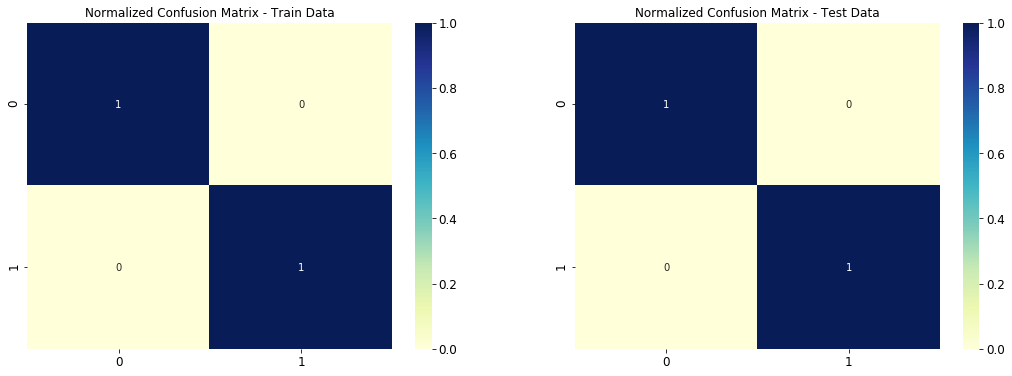

In [95]:
#Let us check the performance of RandomForest after removing few features
build_model_train_test(rnd_clf,x_train,x_test,y_train,y_test)

In [240]:
testdata1.head()

,campaign_id,webpage_id,product_category_1,user_group_id,age_level,user_depth,var_1,product_A,product_B,product_C,product_D,product_E,product_F,product_G,product_H,product_I,product_J,gender_Female,gender_Male
0,404347,53587,1,5.0,5.0,3.0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,118601,28529,3,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,1,0,0,0
2,118601,28529,4,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,1,0,0,0
3,118601,28529,5,1.0,1.0,3.0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,118601,28529,5,9.0,3.0,1.0,1,0,0,0,0,0,0,0,1,0,0,1,0


In [244]:
testdata2=testdata1.fillna(testdata1.median())

In [247]:
testdata2['campaign_id'] = StandardScaler().fit_transform(testdata2['campaign_id'].values.reshape(-1, 1))

In [248]:
testdata2['webpage_id'] = StandardScaler().fit_transform(testdata2['webpage_id'].values.reshape(-1, 1))
testdata2.describe() 

,campaign_id,webpage_id,product_category_1,user_group_id,age_level,user_depth,var_1,product_A,product_B,product_C,product_D,product_E,product_F,product_G,product_H,product_I,product_J,gender_Female,gender_Male
count,1.288580e+05,1.288580e+05,128858.000000,128858.000000,128858.000000,128858.000000,128858.000000,128858.000000,128858.000000,128858.000000,128858.000000,128858.000000,128858.000000,128858.000000,128858.00000,128858.000000,128858.000000,128858.000000,128858.000000
mean,-1.018947e-14,3.494457e-15,3.505052,3.509933,2.828160,2.881924,0.387062,0.035527,0.052632,0.214864,0.154542,0.042582,0.010391,0.023367,0.34829,0.098768,0.019036,0.113683,0.842206
std,1.000004e+00,1.000004e+00,1.449608,2.403618,1.070223,0.394878,0.487080,0.185110,0.223298,0.410730,0.361469,0.201913,0.101407,0.151066,0.47643,0.298351,0.136654,0.317427,0.364549
min,-1.097530e+00,-1.336495e+00,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,-9.256503e-01,-8.169630e-01,2.000000,2.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000
50%,-8.337411e-01,1.522072e-01,4.000000,3.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000
75%,9.282086e-01,1.522072e-01,5.000000,4.000000,3.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,1.000000
max,1.315105e+00,1.917648e+00,5.000000,12.000000,6.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


In [249]:
testdata2=sc.transform(testdata2)

In [250]:
testdata2=pd.DataFrame(testdata2)

In [251]:
testdata2.columns=['campaign_id','webpage_id','product_category_1','user_group_id','age_level','user_depth','var_1','product_A','product_B','product_C','product_D','product_E','product_F','product_G','product_H','product_I','product_J','gender_Female','gender_Male']

In [252]:
testdata2.describe()

,campaign_id,webpage_id,product_category_1,user_group_id,age_level,user_depth,var_1,product_A,product_B,product_C,product_D,product_E,product_F,product_G,product_H,product_I,product_J,gender_Female,gender_Male
count,128858.000000,128858.000000,128858.000000,128858.000000,128858.000000,128858.000000,128858.000000,128858.000000,128858.000000,128858.000000,128858.000000,128858.000000,128858.000000,128858.000000,128858.000000,128858.000000,128858.000000,128858.000000,128858.000000
mean,-2.433867,-1.377984,0.322889,0.011481,0.040981,0.008933,-0.083398,0.014720,0.023378,-0.293032,0.230562,-0.018209,-0.037196,0.019613,0.265230,-0.110984,-0.013091,-0.008417,-0.129135
std,0.000008,0.000046,1.114659,0.994312,1.000170,0.985977,0.984324,1.037728,1.048210,0.858295,1.269980,0.959769,0.837093,1.063992,1.122479,0.867898,0.955076,0.989848,1.136789
min,-2.433876,-1.378046,-1.603342,-1.440484,-2.602057,-4.690075,-0.865599,-0.184448,-0.223687,-0.742031,-0.312404,-0.220616,-0.122974,-0.144964,-0.555349,-0.398297,-0.146137,-0.362921,-2.755423
25%,-2.433874,-1.378022,-0.834404,-0.613138,-0.732970,0.303758,-0.865599,-0.184448,-0.223687,-0.742031,-0.312404,-0.220616,-0.122974,-0.144964,-0.555349,-0.398297,-0.146137,-0.362921,0.362921
50%,-2.433873,-1.377977,0.703473,-0.199465,0.201573,0.303758,-0.865599,-0.184448,-0.223687,-0.742031,-0.312404,-0.220616,-0.122974,-0.144964,-0.555349,-0.398297,-0.146137,-0.362921,0.362921
75%,-2.433860,-1.377977,1.472412,0.214208,0.201573,0.303758,1.155269,-0.184448,-0.223687,-0.742031,-0.312404,-0.220616,-0.122974,-0.144964,1.800670,-0.398297,-0.146137,-0.362921,0.362921
max,-2.433857,-1.377895,1.472412,3.523592,3.005203,0.303758,1.155269,5.421574,4.470539,1.347653,3.200980,4.532765,8.131806,6.898256,1.800670,2.510688,6.842890,2.755423,0.362921


In [253]:
testdata2.drop(labels = ['product_E','product_J'], axis = 1, inplace=True)
testdata2.columns

Index(['campaign_id', 'webpage_id', 'product_category_1', 'user_group_id',
       'age_level', 'user_depth', 'var_1', 'product_A', 'product_B',
       'product_C', 'product_D', 'product_F', 'product_G', 'product_H',
       'product_I', 'gender_Female', 'gender_Male'],
      dtype='object')

In [254]:
testdata2['is_click']=rnd_clf.predict(testdata2)

In [255]:
testdata2['session_id']=testdata['session_id']

In [256]:
testdata2=testdata2.filter(['session_id','is_click'])

In [258]:
testdata2.head()

,session_id,is_click
0,411705,1
1,208263,1
2,239450,1
3,547761,1
4,574275,0


In [259]:
testdata2.to_csv('test_output10.csv', sep=',',index=False)